# LRP

OVA SVESKA SE MOZE IZVRSAVATI

**LRP** (*layer-wise relevance propagation*) je tehnika (skup pravila) koja nam omugacava da za klasifikovanu instancu (u nasem slucaju tekst) odredimo koji atributi (reci) su u kojoj meri doprineli toj klasifikaciji.

Zasniva se na dodeljivanju  ***ocena relevantnosti*** (**doprinosa**) komponentama modela - od izlaza do ulaza.


Posebno je zanimljivo ovakve metode prilagoditi nelinearnim modelima npr. neuronskim mrezama. <br>
Kod neuronskih mreza svaki neuron imace svoju ocenu relevantnosti. <br>
Ocene ce se propagirati od izlaza sve do ulaza, prateci *zakon odrzanja* - svaki sloj sumu relevantnosti svojih neurona predaje sloju ispod (sloju blizem ulazu).

Zakon odrzanja relevantnosti moze se opisati sledecom formulom: 

<img src= ".\images\LRP_conservation.png" width ="200" heigth="10"></img>

gde *k* i *j* predstavljaju neurone susednih slojeva.

<img src=".\images\LRP_img.png"></img>

Dalje navodimo pravila racunanja relevantnosti neurona na osnovu relevantnosti neurona sloja iznad.

### Osnovno pravilo (*LRP-0*):

<img src=".\images\LRP_0.png" width="280" height="20"></img>

### ε - pravilo (*LRP-ε*):

<img src=".\images\LRP_eps.png" width="300" height="20"></img>

### γ - pravilo (*LRP-γ*):

<img src=".\images\LRP_gamma.png" width="330" height="20"></img>

### Generalno pravilo:

<img src=".\images\LRP_general.png" width="300" height="20"></img>

- ***a<sub>j</sub>*** predstavlja vrednost aktivacije *j*-tog neurona
- ***w<sub>jk</sub>*** tezinu koja spaja neuron *j* i neuron *k*
- ***ε*** je konstanta koja sprecava deljenje malim brojem, a takodje utice i na eliminaciju slabih doprinosa
- ***γ*** je konstanta kojom favorizujemo pozitivne doprinose
- ***ρ*** je uopstenje transformacije tezina (moze se eksperimentisati)

Preporuke za koriscenje ovih pravila po slojevima: 

<img src=".\images\LRP_layers.png"></img>

---

## Nas CNN model

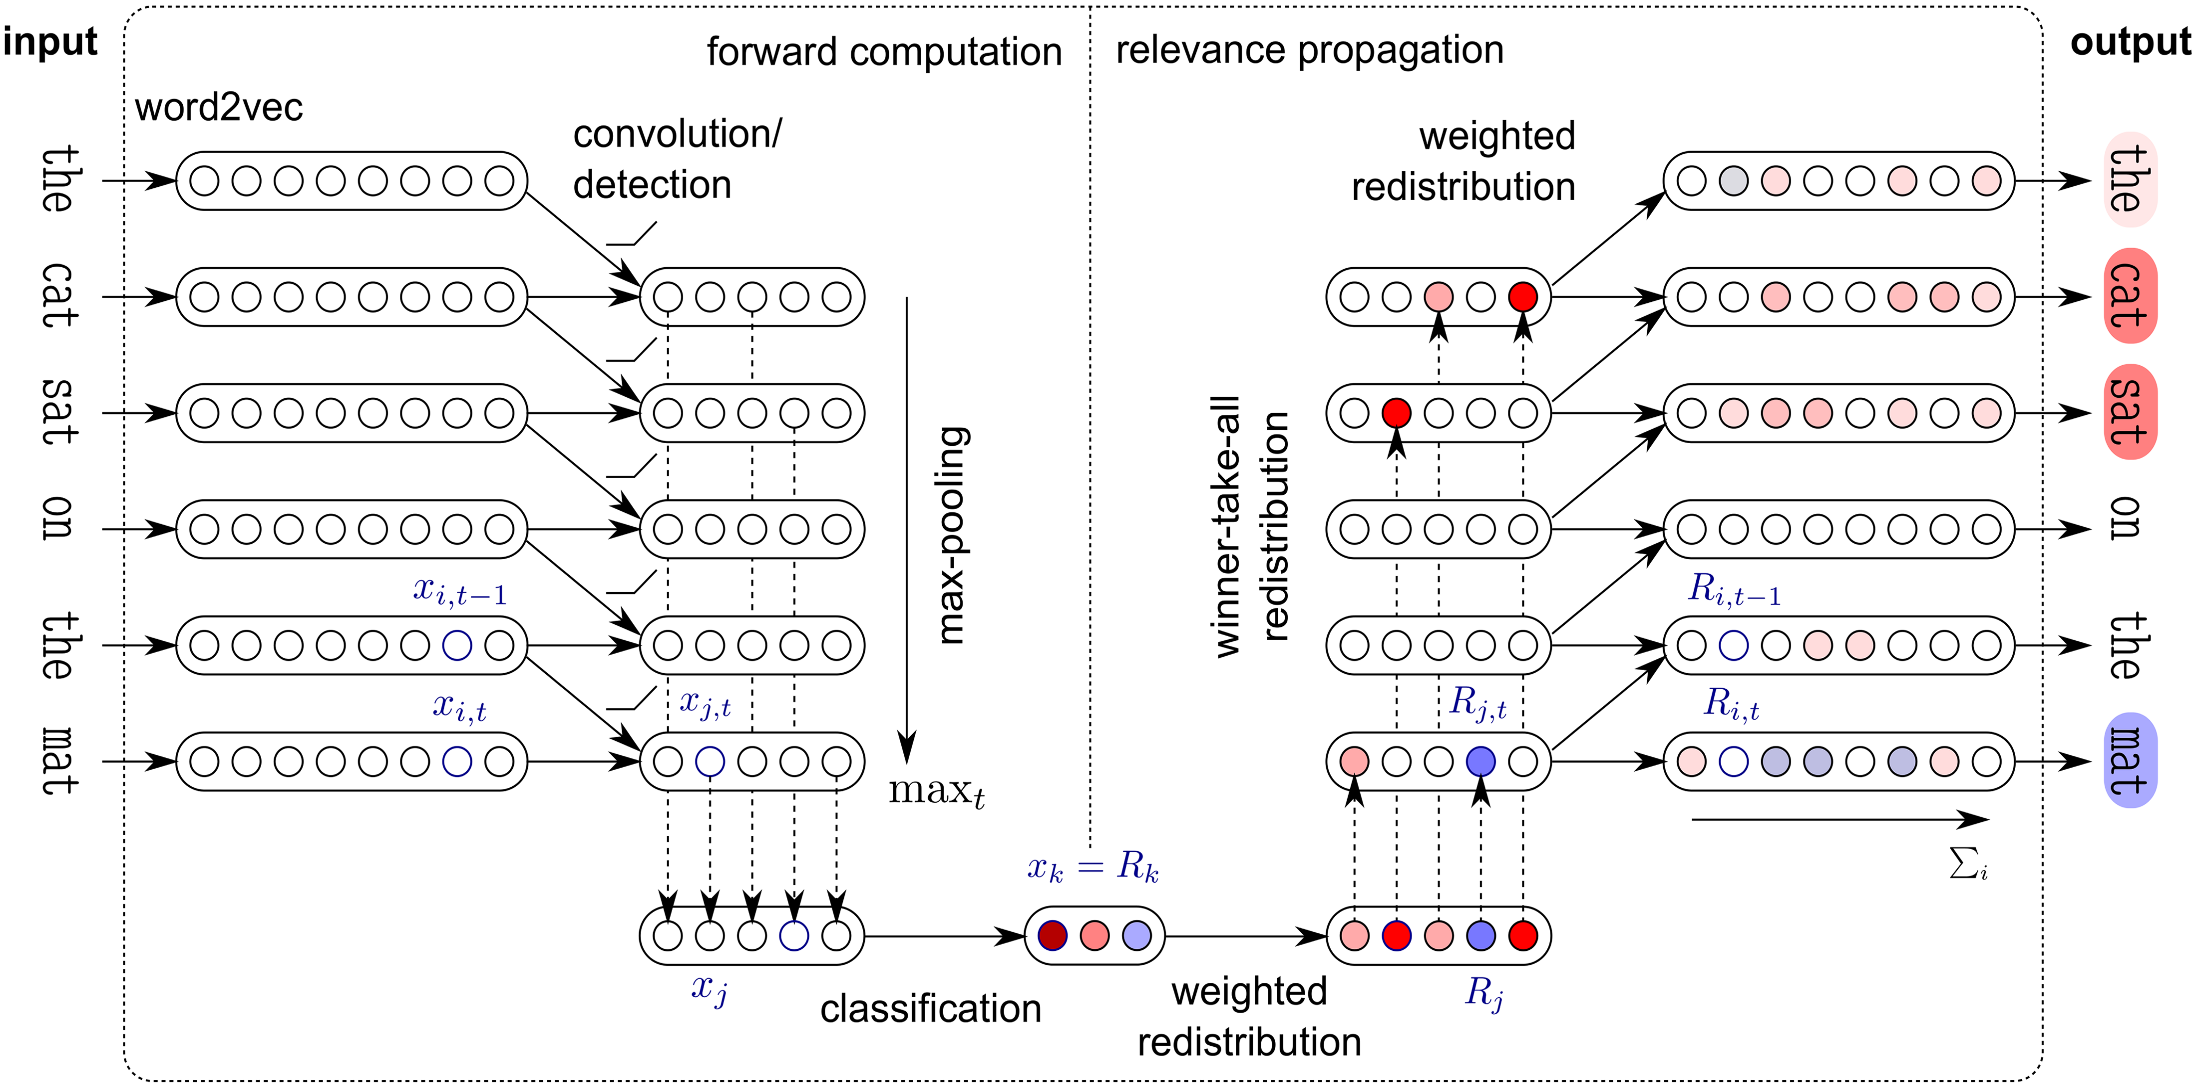

### *GlobalMaxPool* pravilo:

Kod ditribucije relevantnosti u ***GlobalMaxPool*** sloju koristimo *winner-take-all* strategiju odn.
neuron koji je imao najvecu aktivaciju (posle ***Conv*** sloja i ***Relu*** aktivacije) dobice celokupnu ocenu relevantnosti neurona iz sloja iznad (na slici - sloja ispod).

4 koraka za racunanje LRP:

<img src=".\images\LRP_4_steps.png"></img>

In [1]:
import numpy as np

In [2]:
def relprop(w, a, Rk, eps=0.01, rho=lambda x: x):
    # GORNJI SLOJ (onaj cije R imamo, koji predaje dalje)
    # DONJI SLOJ (onaj cije R racunamo)
    # w - tezine (wjk - j donji sloj, k gornji sloj ) - dim=(m,n)
    # a - aktivacije donjeg sloja - dim=(m)
    # R - relevantnosti gornjeg sloja - dim=(n) 
    
    n = len(Rk)    
    m = len(a)
    
    z = np.array([eps + np.dot(a, rho(w[:,k])) for k in range(n)])
    s = np.array([Rk[k] / z[k] for k in range(n)])
    c = np.array([np.dot(rho(w[j]),s) for j in range(m)])
    Rj = np.array([a[j]*c[j] for j in range(m)])
    
    return Rj

Mi cemo koristiti modifikovanu verziju:

<img src=".\images\lrp_dense.png"></img>
<img src=".\images\lrp_dense2.png"></img>
<img src=".\images\lrp_dense3.png"></img>



In [3]:
def relprop_dense(wb, aj, ak, F, Rk, eps=0.01, rho=lambda x: x):
    # GORNJI SLOJ (onaj cije R imamo, koji predaje dalje)
    # DONJI SLOJ (onaj cije R racunamo)
    # w - tezine (w0jk - j donji sloj, k gornji sloj ), w1j su bias (b) - dim=(2,m,n) 
    # aj - aktivacije donjeg sloja (na slici gore - xj)- dim=(m)
    # ak - aktivacije gornjeg sloja (na slici gore - xk)
    # R - relevantnosti gornjeg sloja - dim=(n) 
    # F - sirina filtera
    
    w = wb[0]
    b = wb[1]
    
    n = len(Rk)    
    m = len(aj)
    
    zjk = np.array([[ aj[j]*w[j][k] + (1/F)*(b[k] + eps*np.sign(ak[k])) for k in range(n)] for j in range(m)])
    
    R = [np.sum(np.array([zjk[j][k]/np.sum(zjk[:, k])*Rk[k] for k in range(n)]))  for j in range(m)]
    
    return R
    


In [4]:
def relprop_maxpool(X, Rj):
    #winner-take-all
    
    Rm = np.zeros(X.shape)
    for i in range(X.shape[1]):
        winner = np.argmax(X[:,i])
        Rm[winner][i] = Rj[i]
        
    return Rm

Propagacija R izmedju ***Conv*** i ***Embedding*** sloja (poslednja propagacija):

<img src=".\images\lrp_conv1.png"></img>
<img src=".\images\lrp_conv2.png"></img>
<img src=".\images\lrp_conv3.png"></img>

In [6]:
# Pravilo za konvoluciju adaptirano iz formule gore

def relprop_convolution2(xit, xjt, wb, window_size, F, H, D, Rjt, eps=0.01):
     #x je word2vec
     #wb je tenzor tezina konvolucije (i bias-a)
     #F broj filtera
     #H je maksimalna duzina dokumenta
     #D je velicina word2vec vektora
     #Rjt su prethodne relevantnosti
    
    #TAU_RANGE = H - window_size + 1
    tau = window_size
    
    xit = np.transpose(xit)
    xjt = np.transpose(xjt)
    Rjt = np.transpose(Rjt)
    
    
    w = wb[0]
    b = wb[1] 
    
    Rit = np.zeros((D, H))
    
    
    # Prepravimo malo (deluje smislenije)
    hd = 1/(tau*D)
    
    zijt = np.zeros((D, F, H))
    
    zero_words = np.array([np.count_nonzero(xit[:,t]) for t in range(H)])
    
    # POTREBNO PUNO ODSECANJA (if - continueo)
    # nacelno se jako dugo izvrsava, 4tvorostruka petlja, slozene operacije nad visedimenzionim nizovima...
    # trebalo bi da se izvrsi za nekoliko sekundi do nekoliko desetina sekundi sa ovim modifikacijama
    
    # koliko ukupno Rjt predaje
    rjt_sum = np.zeros((F,H-tau))
    
    
    
    for j in range(F):
        #print(j)
        for t in range(H-tau):
            #print(j, t)
            rjt_sum[j][t] = (w[:,:,j].transpose()*xit[:, t:t+tau]).sum() + b[j] + eps*np.sign(xjt[j][t])
            
    for s in range(tau):
        for t in range(H-tau+s):
            #print(t)
            if(zero_words[t]==0):
                continue
            for j in range(F):
                if Rjt[j][t-s] == 0:
                    continue
                for i in range(D):
                    Rit[i][t] += ((xit[i][t]*w[s][i][j] + hd*(b[j] + eps*np.sign(xjt[j][t-s])))/rjt_sum[j][t-s])*Rjt[j][t-s]
            
                    
    return Rit
            
    
    
    

In [7]:
# Konacni LRP koji propagira R od vrha mreze (izlaza) do dna (ulaza) 
# koristeci ranije implementirane funkcije

def LRP(model, inp, cat, eps=0.01):
    F = model.layers[2].output_shape[2]
    H = model.input_shape[1]
    D = model.layers[0].output_shape[2]
    
    
    window_size = H - model.layers[2].output_shape[1] + 1
    
    print(window_size)
    
    wb_conv_to_emb = model.layers[2].get_weights()
    wb_dense_to_end = model.layers[-1].get_weights()
    activation_conv = backend.function([model.layers[0].input], [model.layers[2].output])
    activation_dense = backend.function([model.layers[0].input], [model.layers[3].output])
    activation_end = backend.function([model.layers[0].input], [model.layers[-1].output])
    
    Rk = np.zeros(20)
    Rk[cat] = activation_end(inp)[0][0][cat]
    
    Rj = relprop_dense(wb_dense_to_end, activation_dense(inp)[0][0], activation_end(inp)[0][0], F, Rk, eps=eps)
    
    Rp = relprop_maxpool(activation_conv(inp)[0][0], Rj)
    
    Ri = relprop_convolution2(model.layers[0].get_weights()[0][inp][0], activation_conv(inp)[0][0], wb_conv_to_emb, window_size=window_size, F=F, H=H, D=D, Rjt=Rp, eps=eps)
    
    return Ri

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalMaxPool1D, Conv1D, Embedding, Dropout, MaxPool1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [9]:
from tensorflow.keras.utils import to_categorical

In [10]:
from sklearn import datasets

In [11]:
import os

In [12]:
import pickle

In [13]:
import gensim

In [14]:
from matplotlib import pyplot as plt

In [15]:
import matplotlib

In [23]:
import nltk

### Ucitavanje i priprema podataka

In [16]:
max_doc_len = 400

In [17]:
model = load_model(os.path.join("models", "best_cnn.hdf5"))

In [18]:
test_data = datasets.fetch_20newsgroups(random_state=61, subset='test', remove=('headers'))
train_data = datasets.fetch_20newsgroups(random_state=61, remove=('headers'))
X_train = train_data.data
y_train = train_data.target
X_test = test_data.data
y_test = test_data.target
feature_names = test_data.target_names

In [24]:
X_train_tok = [nltk.tokenize.word_tokenize(text) for text in X_train]
X_test_tok = [nltk.tokenize.word_tokenize(text) for text in X_test] 

In [19]:
with open(os.path.join("data", "googlew2v_vocab.pickle"), "rb") as load_file:
    googlew2v_vocab = pickle.load(load_file)

In [20]:
googlew2v_index_to_key = { index : key for (key,index) in zip(list(googlew2v_vocab.keys()), range(1,len(googlew2v_vocab)+1))}

In [21]:
googlew2v_key_to_index = { googlew2v_index_to_key[index] : index for index in googlew2v_index_to_key }

In [25]:
X_train_tok_filt = [[word for word in text if word in googlew2v_key_to_index] for text in X_train_tok]
X_test_tok_filt = [[word for word in text if word in googlew2v_key_to_index] for text in X_test_tok]

In [26]:
X_google_train_idx = [[googlew2v_key_to_index[word] for word in text if word in googlew2v_key_to_index] for text in X_train_tok_filt]
X_google_test_idx = [[googlew2v_key_to_index[word] for word in text if word in googlew2v_key_to_index] for text in X_test_tok_filt]

In [27]:
X_train_google_input = pad_sequences(X_google_train_idx, maxlen=max_doc_len)
X_test_google_input = pad_sequences(X_google_test_idx, maxlen=max_doc_len)

In [57]:
# ako hocemo neki nas tekst da koristimo (koji nije u train i test) - funkcija za pripremu
# od sirovog teksta (stringa) do spremnog ulaza u mrezu ili LRP

In [32]:
# varijanta kad nepoznatu rec izbacimo

In [30]:
def prepare_input(text):
    text = nltk.tokenize.word_tokenize(text)
    text_idx = np.array([googlew2v_key_to_index[word] for word in text if word in googlew2v_key_to_index])
    text_idx_padded = pad_sequences([text_idx], maxlen=max_doc_len)[0]
    
    return np.array([text_idx_padded])

In [34]:
# varijanta kad nepoznatu rec zamenimo sa 0 (preferirano)

In [35]:
def prepare_input_with0(text):
    text = nltk.tokenize.word_tokenize(text)
    text_idx = np.array([googlew2v_key_to_index[word] if word in googlew2v_key_to_index else 0 for word in text])
    text_idx_padded = pad_sequences([text_idx], maxlen=max_doc_len)[0]
    
    return np.array([text_idx_padded])

### Testiranje LRP metode

In [38]:
def plot_relevance(R, words, num_rows=10):
    Rtoplot = R.reshape(40, 10)[-num_rows:]
    wtoplot = words.reshape(40,10)[-num_rows:]
    
    plt.figure(figsize=(24,15))

    im = plt.imshow(Rtoplot[-num_rows:], cmap='coolwarm')

    plt.xticks([])
    plt.yticks([])

    plt.colorbar()

    anot = wtoplot[-num_rows:]
    for i in range(anot.shape[0]):
        for j in range(anot.shape[1]):
            im.axes.text(j, i, anot[i, j], ha='center')
    
    
    

In [45]:
def show_relevance(text, model, epsilon=0.01):
    if len(text) < 1000:
        print(text)
        
    # pripremamo tekst (prebacujemo ga u indeksnu reprezentaciju - rec u indeks)
    text_input = prepare_input_with0(text)
    
    prediction = model.predict([text_input])[0]
    # predvidjamo kategoriju
    cat = np.argmax(prediction)
    # koliko je model siguran
    certainty = prediction.max()
    
    print("-----------------")
    print("Predicted category: ", feature_names[cat])
    print("with certainty of: ", certainty)
    print("-----------------")
    
    # odredjujemo inicijalne relevantnosti (rasporedjene po vektorima reci)
    R = LRP(model, text_input, cat, epsilon)
    
    # sumiramo ih da dobijemo relevantnost svake reci
    relevances = R.transpose().sum(axis=1)
    
    # skaliramo relevantnosti
    
    relevances_scaled = relevances#(relevances - relevances.mean())/relevances.std()
    
    # sortiramo reci po relevantnosti
    rel_sorted = np.argsort(relevances_scaled)
    
    
    # prebacimo tekst u listu reci
    words = np.array([googlew2v_index_to_key[index] if index > 0 else "*" for index in text_input[0]])
    
    # Ovo je ako hocemo da ispisemo i tokene koji se ne javljaju u trening skupu
    # mogu biti dugacki, te lose uticati na izgled, pa cemo ovo izbeci
    
    #tokenized_text = np.array(vectorizer.tokenizer(text)) 
    #words = 400*["_"]
    #for i in range(max(0,400-len(tokenized_text)), 400):
    #    words[i] = tokenized_text[i - 400 + len(tokenized_text)]
        # obelezavamo "nove reci" zvezdicom * (one koje nismo uhvatili u treningu)
    #    words[i] += "*" if tokenized_text[i - 400 + len(tokenized_text)] not in cbow_key_to_index else ""
    #words = np.array(words)
    
    
    # ispisemo po 5 najuticajnih reci (5 pozitivnih i 5 negativnih)
    print("5 most posive words: ")
    for i in range(1,6):
        print(f"[{words[rel_sorted][-i]}]", " with score: ", relevances_scaled[rel_sorted[-i]])
        
    print("5 most negative words: ")
    for i in range(5):
        print(f"[{words[rel_sorted][i]}]", " with score: ", relevances_scaled[rel_sorted[i]])
        
    # iscrtamo heatmap-u poslednjih 10*num_rows reci teksta (poslednjih zbog prepadding-a)
    
    
    plot_relevance(relevances_scaled, words, num_rows=15)
    

In [29]:
# za demonstraciju necemo uzeti random instance

#train_instances = np.random.randint(0, len(X_train), size=3)

In [41]:
print(feature_names)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [173]:
# izaberimo po jednu instancu iz sledecih oblasti:
# comp.graphics - 1
# sci.med - 13
# sci.space - 14

In [181]:
# NAPOMENA: iako je ranije naglaseno, reci koje NISU istrenirane u trening skupu bice zamenjene * (nemaju uticaj svakako)
# kako bi vizuelno bilo preglednije, prikazujemo samo poslednjih 150 reci teksta (poslednjih zbog pre-padding-a)

In [43]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

From article <1993Apr21.013846.1374@cx5.com>, by tlc@cx5.com:
> 
> 
> I've got an old demo disk that I need to view. It was made using RIX Softworks.  
> The files on the two diskette set end with: .scf
> 
> The demo was VGA resolution (256 colors), but I don't know the spatial  
> resolution.
> 

According to my ColoRIX manual .SCF files are 640x480x256

> First problem: When I try to run the demo, the screen has two black bars that  
> cut across (horizontally) the screen, in the top third and bottom third of the  
> screen. The bars are about 1-inch wide. Other than this, the demo (the  
> animation part) seems to be running fine.
> 
> Second problem: I can't find any graphics program that will open and display  
> these files. I have a couple of image conversion programs, none mention .scf  
> files.
> 

You may try VPIC, I think it handles the 256 color RIX files OK..


Rob Sherry
sherry@a.cs.okstate.edu

1/1 [==============================] - 0s 20ms/step
-----------------
Predic

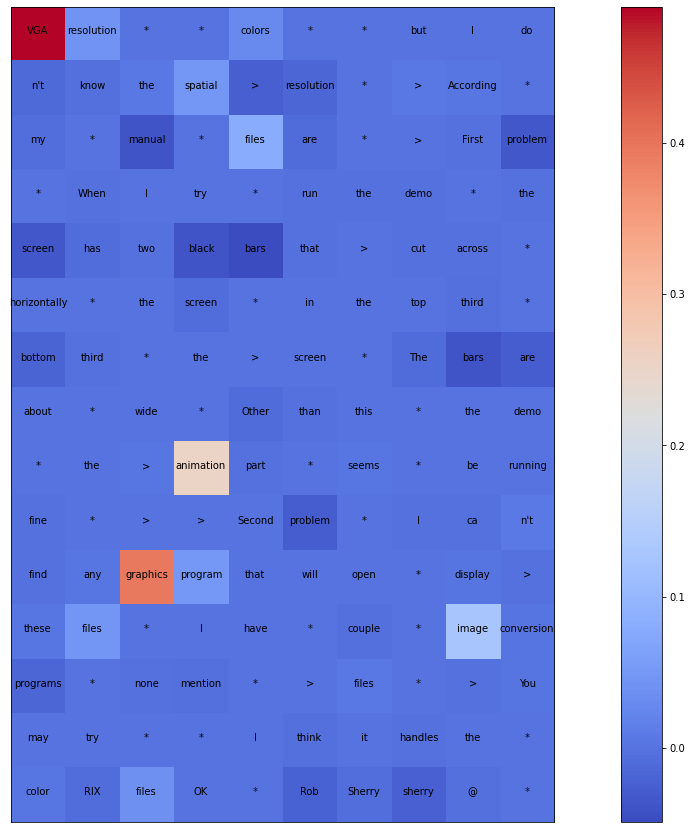

In [46]:
show_relevance(X_train[y_train == 1][19], model)

1/1 [==============================] - 0s 17ms/step
-----------------
Predicted category:  sci.med
with certainty of:  0.99505144
-----------------
2
5 most posive words: 
[symptoms]  with score:  0.7513434533150624
[migraine]  with score:  0.33265616891525596
[onset]  with score:  0.128648511907179
[Dehydration]  with score:  0.11169628231006676
[migraines]  with score:  0.09239557738669966
5 most negative words: 
[tennis]  with score:  -0.11212197589222953
[#]  with score:  -0.05521468635919776
[per]  with score:  -0.05020190347994865
[play]  with score:  -0.031642400981938504
[mine]  with score:  -0.0283746768162971


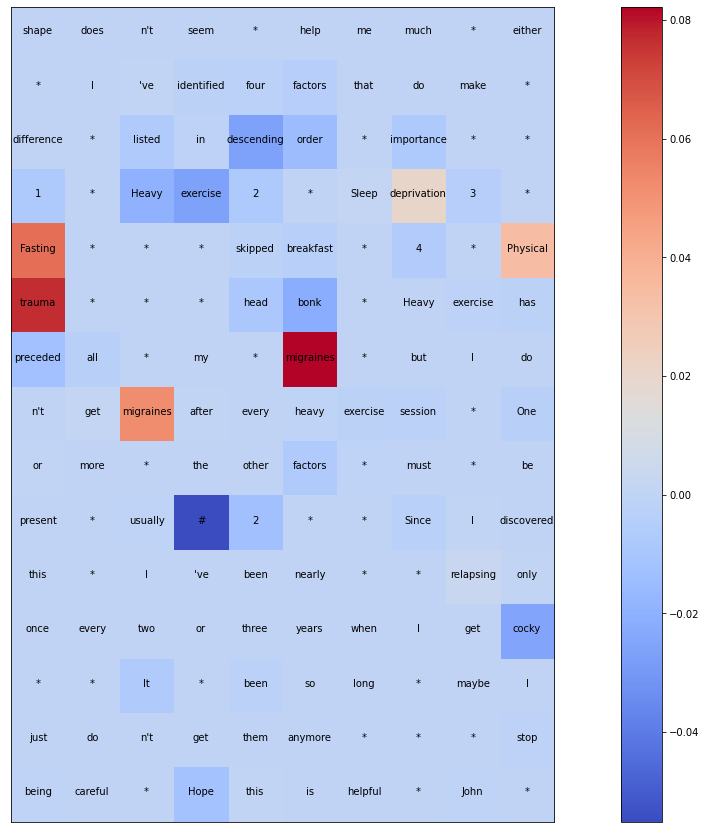

In [47]:
show_relevance(X_train[y_train==13][91], model)

1/1 [==============================] - 0s 15ms/step
-----------------
Predicted category:  sci.space
with certainty of:  0.999529
-----------------
2
5 most posive words: 
[spacecraft]  with score:  1.1780745223807592
[spacecraft]  with score:  0.45878028084511085
[article]  with score:  0.05430948033845599
[Earth]  with score:  0.041761553836238786
[assumes]  with score:  0.03323625529538756
5 most negative words: 
[Baalke]  with score:  -0.12279405071089813
[Telos]  with score:  -0.1061380605985088
[Timer]  with score:  -0.061195963985959556
[protection]  with score:  -0.059831455023237834
[cruise]  with score:  -0.0361043318366291


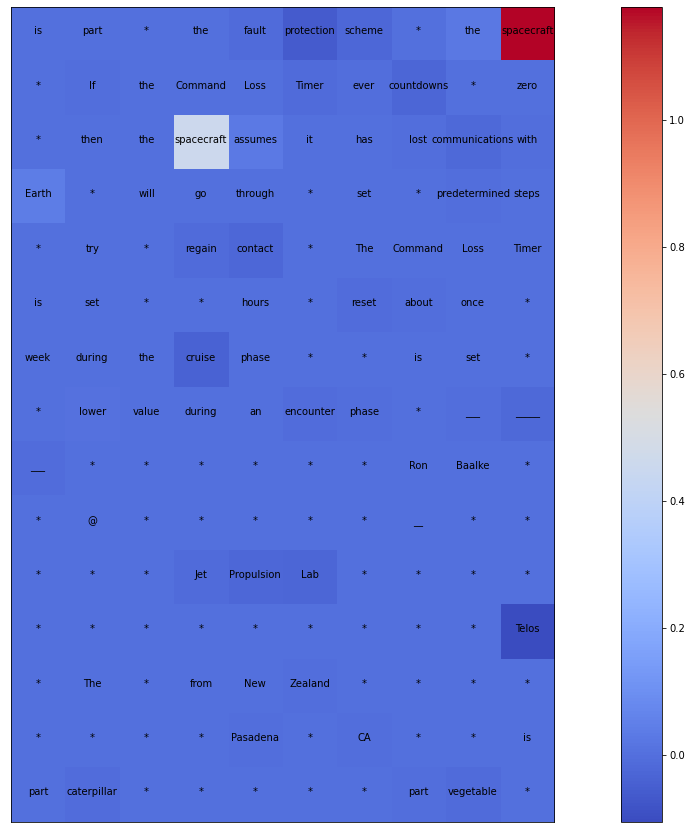

In [48]:
show_relevance(X_train[y_train==14][12], model)

1/1 [==============================] - 0s 14ms/step
-----------------
Predicted category:  soc.religion.christian
with certainty of:  0.9685273
-----------------
2
5 most posive words: 
[theologians]  with score:  0.19658752212417877
[Orthodox]  with score:  0.18277147605158306
[Christ]  with score:  0.17661767986327367
[Christ]  with score:  0.17246583679070765
[Catholics]  with score:  0.15380636042974638
5 most negative words: 
[Finnerty]  with score:  -0.0734400012549135
[Icon]  with score:  -0.05881803016038946
[asleep]  with score:  -0.04159047270148095
[Word]  with score:  -0.03751319141531115
[doctrine]  with score:  -0.02703789584981713


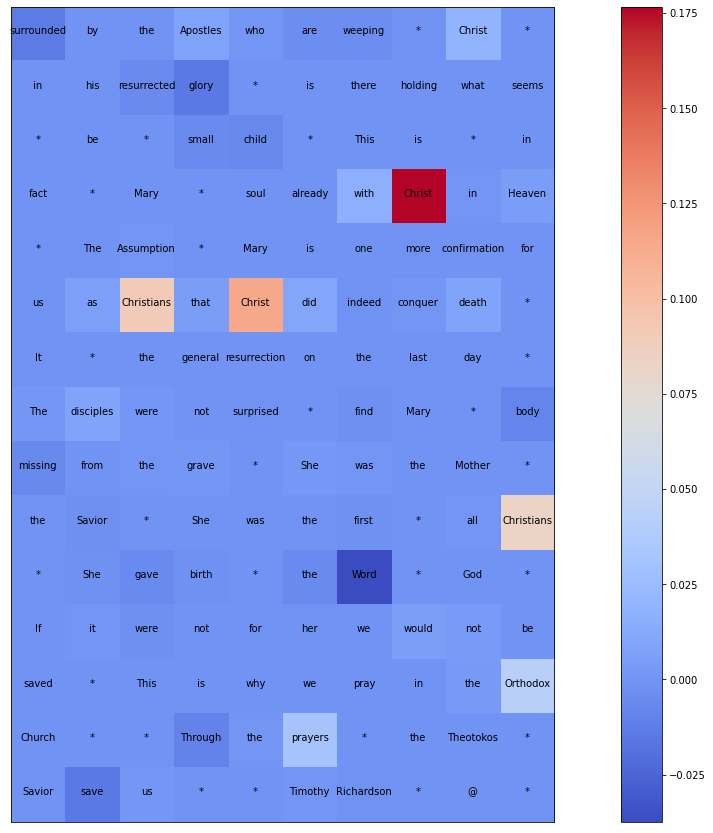

In [53]:
show_relevance(X_test[np.random.randint(len(X_test))], model)

In [49]:
# KOMENTAR PRE KORISCENJA GOOGLE W2V VEKTORA (kad smo koristili nase vektore)
# - veliki uticaj stop reci, ne mnogo smislene relevantnosti...

# moguci problemi:
#    1. Los embeding (probati google-ov - oko 3 miliona reci)
#    2. Lose istrenirana mreza ili losa arhitektura
#    3. Skup podataka siromasan
#    4. Stop reci (izbaciti i probati)
#    5. Sama LRP metoda (proveriti greske, isprobati epsilon, ...)

In [56]:
# FINALNI KOMENTAR:
# - ispostavilo se da je 1. problem !!!
# - izuzetno lepi i smisleni rezultati nakon ispravke (prelaska na google w2v)